# Homework 3

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

# 1. Modeling Volatility and VaR

## Data

Find the data file `spy_data.xlsx`.

* Use the returns on the S&P 500 (`SPY`) and 1-month T-bills (`^IRX`).

* Calculate the excess market returns, using the treasury rate as the risk-free rate.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data from the Excel file
file_path = '/Users/apple/Desktop/Uchicago/Untitled/data/spy_data.xlsx'  # Adjust the path as needed
data = pd.read_excel(file_path, sheet_name='total returns')

# Display the first few rows of the data to understand the structure
data.head()

,date,SPY,^IRX
0,1994-01-04,0.004035,0.000122
1,1994-01-05,0.002009,0.000122
2,1994-01-06,0.000000,0.000121
3,1994-01-07,0.006016,0.000119
4,1994-01-10,0.011960,0.000119


In [8]:
# Calculate excess returns: SPY_Return - T-Bill Rate (risk-free rate)
data['Excess_Return'] = data['SPY'] - data['^IRX']
# Display the first few rows with the calculated excess returns
data[['date', 'SPY', '^IRX', 'Excess_Return']].head()


,date,SPY,^IRX,Excess_Return
0,1994-01-04,0.004035,0.000122,0.003913
1,1994-01-05,0.002009,0.000122,0.001888
2,1994-01-06,0.000000,0.000121,-0.000121
3,1994-01-07,0.006016,0.000119,0.005897
4,1994-01-10,0.011960,0.000119,0.011841


***

## 1.1 Historic VaR.
Starting at `Jan 2, 2001`, calculate the historic-based VaR, based on the expanding sample from the first date through `Dec 29, 2000`. 

Denote $\tilde{r}^{VaR, 0.05}_{t}$ as the estimate of the time-t VaR based on data through $t − 1$.

### Report
Report the items below, starting at , starting at `Jan 2, 2001`.

* Plot $\tilde{r}^{VaR, 0.05}_{t}$ over time.

* Report the frequency of periods in which $\tilde{r} < \tilde{r}^{VaR, 0.05}_{t}$. Compare this to the quantile of $.05$.

* What drawbacks do you see in this historic VaR?

#### Note
By historic VaR, we mean simply taking the 5th quantile for the historic sample up to time $t − 1$. Of course, a sample size that is not a multiple of 100 will require some interpolation to get a 5th quantile. Your statistical package should handle this fine.

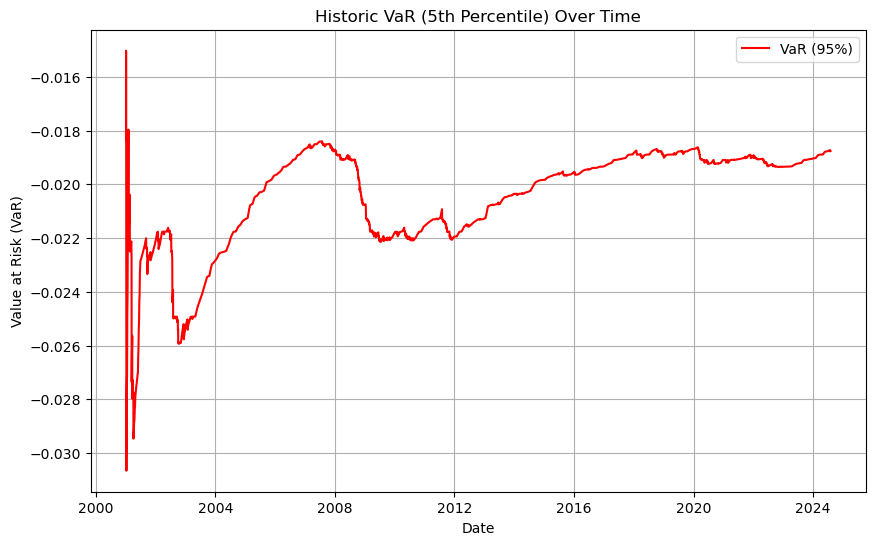

Frequency of returns less than VaR: 4.03%


In [9]:
# Filter the data starting from Jan 2, 2001
start_date = '2001-01-02'
historic_data = data[data['date'] >= start_date].copy()

# Initialize an empty list to store VaR values
VaR_values = []

# Set the confidence level for VaR (95% -> 5th percentile)
confidence_level = 0.05

# Loop through the data to calculate expanding VaR
for i in range(1, len(historic_data)):
    # Take the data up to time t-1 (expanding window)
    data_up_to_t = historic_data['Excess_Return'].iloc[:i]
    
    # Calculate the 5th percentile (VaR) for the data up to time t-1
    VaR_t = np.percentile(data_up_to_t, confidence_level * 100)
    VaR_values.append(VaR_t)

# Add VaR values to the DataFrame (align with dates starting from the second observation)
historic_data = historic_data.iloc[1:].copy()  # Shift data to match VaR calculation
historic_data['VaR_0.05'] = VaR_values

# Plot the VaR over time
plt.figure(figsize=(10, 6))
plt.plot(historic_data['date'], historic_data['VaR_0.05'], label='VaR (95%)', color='red')
plt.title('Historic VaR (5th Percentile) Over Time')
plt.xlabel('Date')
plt.ylabel('Value at Risk (VaR)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the frequency of periods where Excess_Return < VaR
exceedances = historic_data[historic_data['Excess_Return'] < historic_data['VaR_0.05']]
exceedance_frequency = len(exceedances) / len(historic_data)

print(f"Frequency of returns less than VaR: {exceedance_frequency * 100:.2f}%")


The plot shows that the VaR dropped significantly after the market volatility during the early 2000s and the 2008 financial crisis, but then remained relatively stable. This stability could lead to a false sense of security, especially in recent years where the VaR appears low and doesn't account for potential future market shifts.
The Historic VaR is backward-looking and doesn't incorporate any forward-looking information like recent changes in market volatility or economic conditions. If market conditions change rapidly (e.g., COVID-19 or geopolitical risks), this historic VaR wouldn’t adjust in time to provide adequate warning.

***

## 1.2 Volatility
We will calculate a time-series of volatility estimates using a few different methods. For each, we use $\sigma_t$ to denote our estimate of the time-t return volatility.

#### Expanding Series

$$
\sigma^2_{t,expanding} = \frac{1}{t-1}\sum_{\tau = 1}^{t-1}\tilde{r}^2_{\tau}
$$



#### Rolling Window

$$
\sigma^2_{t,rolling} = \frac{1}{m}\sum_{l = 1}^{m}\tilde{r}^2_{t-l}
$$

Use $m=$`252`.


#### Exponentially Weighted Moving Average (EWMA)

Feel free to calculate the EWMA using the following recursion,
$$
\sigma^2_{t, EWMA} = \theta \sigma^2_{t-1, EWMA} + (1-\theta)\tilde{r}^2_{t-1}
$$

Rather than estimating $\theta$, simply use $\theta$ = 0.94, and initialize with 
$$\sigma_{t_0} = \frac{0.20}{\sqrt{252}}$$

### Report
Report the items below, starting at , starting at `Jan 2, 2001`.

* For each of these three methods, plot $\sigma_t$. (Plot the vol, not the variance.)

* For each method, calculate the 5th percentile, 1-day-ahead VaR. We use a slight simplification of the normal VaR formula, by dropping $\mu$ from that formula, and rounding the normal distribution z-score to -1.65.
$$\tilde{r}^{VaR, 0.05}_{t} = −1.65 \sigma_t$$

* For each of these vol-based VaR estimates, calculate the frequency of periods in which $\tilde{r} < \tilde{r}^{VaR, 0.05}_{t}$

* Compare and contrast your results among each other and relative to the historic method in the previous problem.

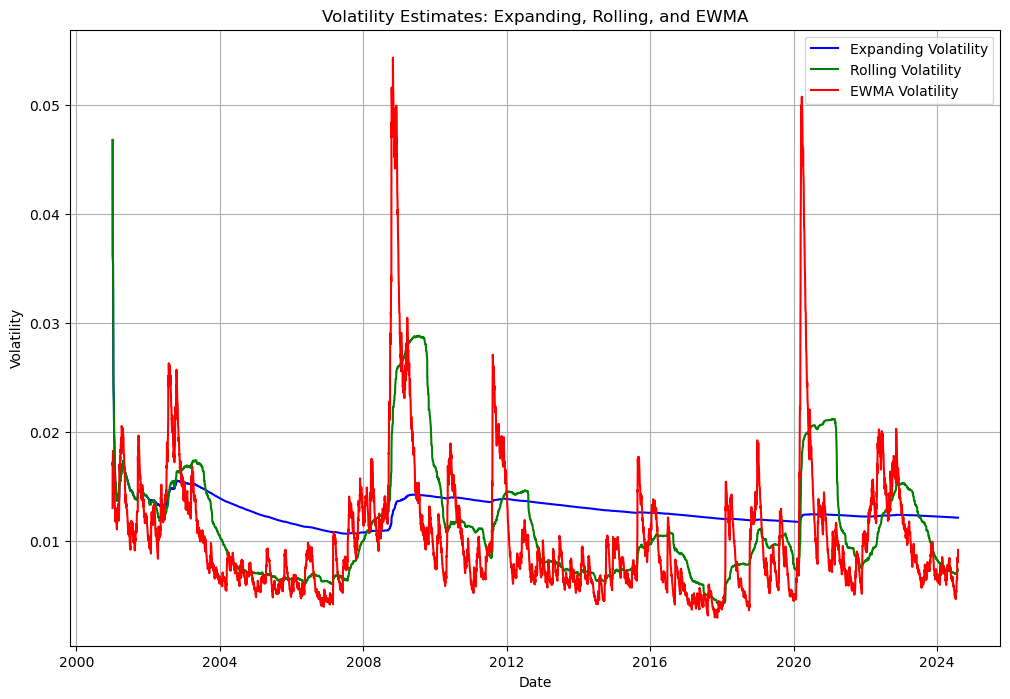

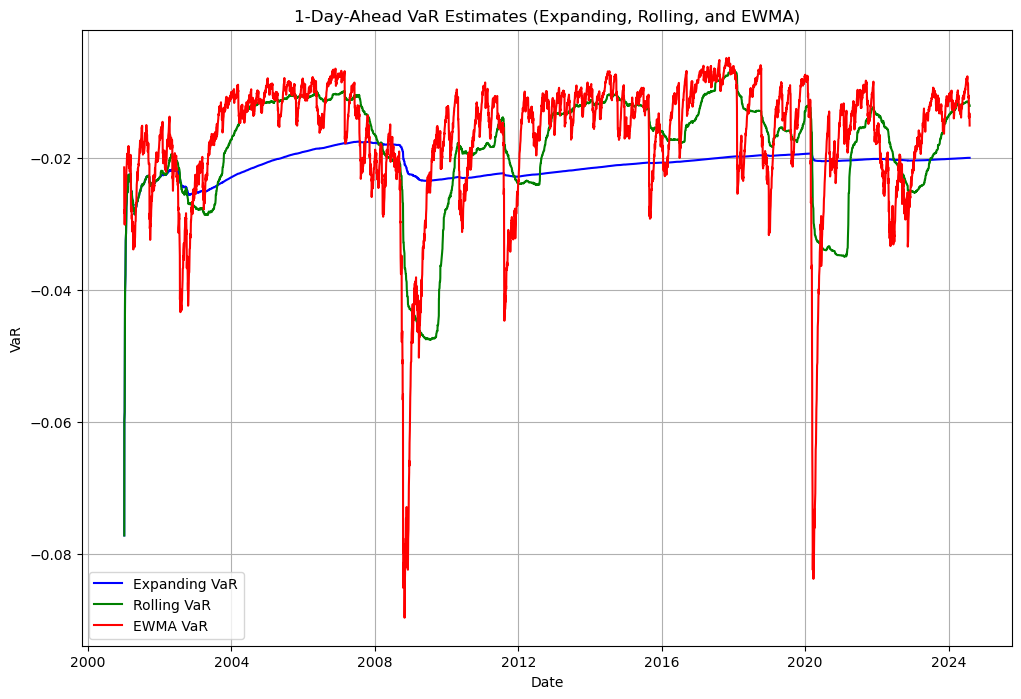

Frequency of returns less than VaR_Expanding: 3.66%
Frequency of returns less than VaR_Rolling: 5.23%
Frequency of returns less than VaR_EWMA: 5.99%


In [10]:
theta = 0.94  # Exponentially Weighted Moving Average parameter
initial_vol = 0.20 / np.sqrt(252)  # Initial volatility estimate
rolling_window_size = 252  # Rolling window size (1 year = 252 trading days)

# Filter data starting from Jan 2, 2001
start_date = '2001-01-02'
vol_data = data[data['date'] >= start_date].copy()

# Initialize empty lists to store volatilities
expanding_vol = []
rolling_vol = []
ewma_vol = []

# Initialize EWMA with the starting value
ewma_var = initial_vol ** 2

# Loop through the data to calculate volatilities
for i in range(1, len(vol_data)):
    # Expanding Volatility (variance)
    var_expanding = np.var(vol_data['Excess_Return'].iloc[:i], ddof=1)
    expanding_vol.append(np.sqrt(var_expanding))
    
    # Rolling Volatility (variance)
    if i >= rolling_window_size:
        var_rolling = np.var(vol_data['Excess_Return'].iloc[i - rolling_window_size:i], ddof=1)
    else:
        var_rolling = np.var(vol_data['Excess_Return'].iloc[:i], ddof=1)
    rolling_vol.append(np.sqrt(var_rolling))
    
    # EWMA Volatility (variance)
    ewma_var = theta * ewma_var + (1 - theta) * vol_data['Excess_Return'].iloc[i - 1] ** 2
    ewma_vol.append(np.sqrt(ewma_var))

# Add volatility estimates to the DataFrame
vol_data = vol_data.iloc[1:]  # Align data (since we start calculating from the second row)
vol_data['Expanding_Vol'] = expanding_vol
vol_data['Rolling_Vol'] = rolling_vol
vol_data['EWMA_Vol'] = ewma_vol

# Plot the volatility estimates
plt.figure(figsize=(12, 8))

# Plot Expanding Volatility
plt.plot(vol_data['date'], vol_data['Expanding_Vol'], label='Expanding Volatility', color='blue')

# Plot Rolling Volatility
plt.plot(vol_data['date'], vol_data['Rolling_Vol'], label='Rolling Volatility', color='green')

# Plot EWMA Volatility
plt.plot(vol_data['date'], vol_data['EWMA_Vol'], label='EWMA Volatility', color='red')

plt.title('Volatility Estimates: Expanding, Rolling, and EWMA')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

# Calculate 1-day-ahead VaR for each method
# Use the normal VaR formula simplification: VaR = -1.65 * Volatility
vol_data['VaR_Expanding'] = -1.65 * vol_data['Expanding_Vol']
vol_data['VaR_Rolling'] = -1.65 * vol_data['Rolling_Vol']
vol_data['VaR_EWMA'] = -1.65 * vol_data['EWMA_Vol']

# Plot the 1-day-ahead VaR estimates
plt.figure(figsize=(12, 8))

# Plot VaR from Expanding Volatility
plt.plot(vol_data['date'], vol_data['VaR_Expanding'], label='Expanding VaR', color='blue')

# Plot VaR from Rolling Volatility
plt.plot(vol_data['date'], vol_data['VaR_Rolling'], label='Rolling VaR', color='green')

# Plot VaR from EWMA Volatility
plt.plot(vol_data['date'], vol_data['VaR_EWMA'], label='EWMA VaR', color='red')

plt.title('1-Day-Ahead VaR Estimates (Expanding, Rolling, and EWMA)')
plt.xlabel('Date')
plt.ylabel('VaR')
plt.legend()
plt.grid(True)
plt.show()

# Calculate frequency of periods in which Excess_Return < VaR
for method in ['VaR_Expanding', 'VaR_Rolling', 'VaR_EWMA']:
    exceedances = vol_data[vol_data['Excess_Return'] < vol_data[method]]
    exceedance_frequency = len(exceedances) / len(vol_data)
    print(f"Frequency of returns less than {method}: {exceedance_frequency * 100:.2f}%")


The Expanding VaR and Volatility estimates are more stable, meaning they react more slowly to market changes, making them better suited for long-term risk estimation. The lower frequency of returns breaching the expanding VaR indicates that this method is more conservative.
The Rolling VaR and Volatility estimates provide a balance between responsiveness and smoothness. This method adapts quicker than the expanding window but does not overreact to every short-term fluctuation, offering a good middle ground for medium-term risk management.
The EWMA VaR and Volatility estimates are the most responsive, closely tracking market conditions and reacting quickly to volatility spikes. However, the higher frequency of returns below the VaR (5.99%) suggests that this method may underpredict extreme risks during turbulent times, making it highly responsive but potentially less reliable for tail risk estimation.

***

## 1.3 CVaR
Re-do the previous two problems, but this time calculating CVaR instead of VaR, (still for $q =$ `.05`.) 

***

## 1.4 GARCH

#### EXTRA: Not Submitted, not covered in Midterm 1

Re-do the VaR and CVaR calculations using a normal model with volatility calculated from a GARCH(1,1).

To estimate GARCH(1,1), try using the ARCH package in Python. The default estimation implementation is fine. You should be familiar with EWMA and GARCH from the August Review.